# Ajuste del modelo en datos supervisados

En  esta  sección,   se define  y  utiliza  la  función  de  entrenamiento  para  ajustar  el  LLM  preentrenado  y  mejorar  su  precisión  en  la  clasificación  de  spam.  El  bucle  de  entrenamiento,  ilustrado  en  la  figura,  es  el  mismo  bucle  de  entrenamiento  general  que  el de la sección 05,  con  la  única  diferencia  de  que se calcula  la  precisión  de  la  clasificación  en  lugar  de  generar  un  texto  de  muestra  para  evaluar  el modelo.

![Texto alternativo](./imgs/6.14.png)

Las  únicas  dos  distinciones  son  que  ahora  se rastrea  la  cantidad  de  ejemplos  de  entrenamiento  vistos  (examples_seen)  en  lugar  de  la  cantidad  de  tokens,  y  se calcula  la  precisión  después  de  cada  época  en  lugar  de  imprimir  un  texto  de  muestra:

In [1]:
import sys
import os

# Obtiene la ruta de la carpeta principal del proyecto (subiendo un nivel desde seccion05)
ruta_proyecto_principal = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Añade esta ruta a la lista de lugares donde Python busca módulos
if ruta_proyecto_principal not in sys.path:
    sys.path.append(ruta_proyecto_principal)

In [2]:
from calcLossClasification import calc_loss_batch, calc_loss_loader,calc_accuracy_loader
import tiktoken
import torch
from gptModelClasification import return_clasification_model
model = return_clasification_model()
tokenizer = tiktoken.get_encoding("gpt2")

from spamDataset import SpamDataset
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 10
train_dataset = SpamDataset(csv_file="CSV/train.csv",max_length=None,tokenizer=tokenizer)
val_dataset = SpamDataset(csv_file="CSV/validation.csv",max_length=train_dataset.max_length,tokenizer=tokenizer)
test_dataset = SpamDataset(csv_file="CSV/test.csv",max_length=train_dataset.max_length,tokenizer=tokenizer)

torch.manual_seed(123)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers,drop_last=True,)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,num_workers=num_workers,drop_last=False,)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,num_workers=num_workers,drop_last=False,)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [8]:

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, tokenizer):
    #inicaliar listas para rastrear pérdidas y ejemplos vistos
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    #buvle de entrenamiento
    for epoch in range(num_epochs):
        model.train()                                             #modelo en modo entrenamiento
        for input_batch, target_batch in train_loader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            optimizer.zero_grad()                                 #reestablecer los gradientes de pérdida de la iteración del lote anterior
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                       #calcular gradiente de pérdida
            optimizer.step()                                    #actualizar los pesos del modelo
            examples_seen += input_batch.shape[0]                 #ejemplos de seguimiento
            global_step += 1
                                                                    #paso de evaluación (opcional)
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                                                                    #calcular la precisión en cada época
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

A  continuación,  se inicaliza el  optimizador,  se establece  el  número  de  épocas  de  entrenamiento  e  inicia  el  entrenamiento  con  la  función  train_classifier_simple .  
Se analizará  la  elección  del  número  de  épocas  de  entrenamiento  después  de  evaluar  los  resultados.  

In [10]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
start_time= time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.100, Val loss 2.286
Ep 1 (Step 000050): Train loss 0.657, Val loss 0.633
Ep 1 (Step 000100): Train loss 0.570, Val loss 0.539
Training accuracy: 70.00% | Validation accuracy: 80.00%
Ep 2 (Step 000150): Train loss 0.455, Val loss 0.454
Ep 2 (Step 000200): Train loss 0.351, Val loss 0.367
Training accuracy: 60.00% | Validation accuracy: 90.00%
Ep 3 (Step 000250): Train loss 0.390, Val loss 0.316
Ep 3 (Step 000300): Train loss 0.342, Val loss 0.302
Training accuracy: 80.00% | Validation accuracy: 100.00%
Ep 4 (Step 000350): Train loss 0.202, Val loss 0.232
Ep 4 (Step 000400): Train loss 0.080, Val loss 0.133
Training accuracy: 90.00% | Validation accuracy: 100.00%
Ep 5 (Step 000450): Train loss 0.172, Val loss 0.124
Ep 5 (Step 000500): Train loss 0.171, Val loss 0.135
Training accuracy: 90.00% | Validation accuracy: 100.00%
Training completed in 0.58 minutes.


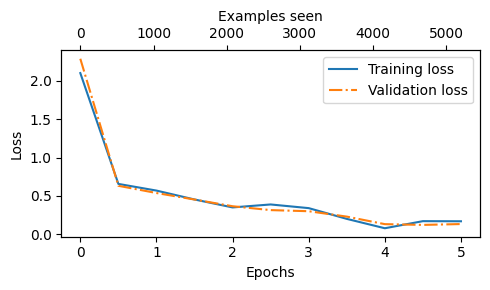

In [12]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()   #segundo eje x para los ejemplos vistos
    ax2.plot(examples_seen, train_values, alpha=0)  
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()                             #ajustar el diseño apra hacer espacio           
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, steps=len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Como  se puede  ver  en  función  de  la  pronunciada  pendiente  descendente  en  la  figura,  el  modelo  está  aprendiendo  bien  de  los  datos  de  entrenamiento  y  hay  poca  o  ninguna  indicación  de  sobreajuste;  es  decir,  no  hay  una  brecha  notable  entre  las  pérdidas  del  conjunto  de  entrenamiento  y  el  de  validación.

###  ELECCIÓN  DEL  NÚMERO  DE  ÉPOCAS
Anteriormente,  al  iniciar  el  entrenamiento, se establecio  el  número  de  épocas  en  5.  Este  número  depende  del  conjunto  de  datos  y  de  la  dificultad  de  la  tarea,  y  no  existe  una  solución  ni  recomendación  universal.  Un  número  de  época  de  5  suele  ser  un  buen  punto  de  partida.
Si  el  modelo  se  sobreajusta  después  de  las  primeras  épocas,  como  podría  indicar  el  gráfico  de  pérdidas  de  la  Figura  6.16,  podríamos  necesitar  reducir  el  número  de  épocas.  Por  el  contrario,  si  la  línea  de  tendencia  sugiere  que  la  pérdida  de  validación  podría  mejorar  con  un  mayor  entrenamiento,  se debería aumentar  el  número  de  épocas.  En  este  caso  concreto,  5  épocas  fue  un  número  razonable,  ya  que  no  hay  indicios  de  sobreajuste  temprano  y  la  pérdida  de  validación  es  cercana  a  cero.

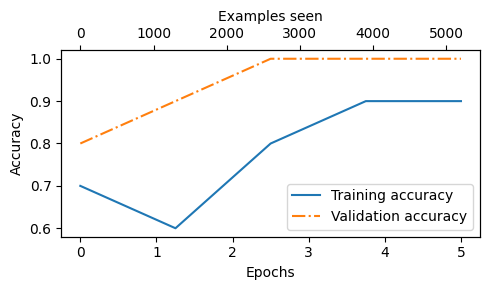

In [13]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Según  el  gráfico  de  precisión  de  la  figura,  el  modelo  logra  una  precisión  de  entrenamiento  y  validación  relativamente  alta  después  de  la época 3.
Sin  embargo,  es  importante  tener  en  cuenta  que  anteriormente  estableció  eval_iter=5  cuando se usó la  función  train_classifier_simple ,  lo  que  significa  que  las estimaciones  del  rendimiento  del  entrenamiento  y  la  validación  se  basaron  en  solo  5  lotes  para  la  eficiencia  durante  el  entrenamiento.
Ahora,  calcualr  las  métricas  de  rendimiento  para  los  conjuntos  de  entrenamiento,  validación  y  prueba  en  todo  el  conjunto  de  datos  ejecutando  el  siguiente  código,  esta  vez  sin  definir  el  valor  eval_iter :

In [15]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 90.00%


Los  rendimientos  del  conjunto  de  entrenamiento  y  de  prueba  son   idénticos.

Una  ligera  discrepancia  entre  la  precisión  de  los  conjuntos  de  entrenamiento  y  de  prueba  sugiere  un  sobreajuste  mínimo  de  los  datos  de  entrenamiento.  Normalmente,  la  precisión  del  conjunto  de  validación  es  ligeramente  superior  a  la  del  conjunto  de  prueba,  ya  que  el  desarrollo  del  modelo  suele  implicar  el  ajuste  de  hiperparámetros  para  un  buen  rendimiento  en  el  conjunto  de  validación,  lo  cual  podría  no  generalizarse  con  la  misma  eficacia  al  conjunto  de  prueba.

Esta  situación  es  común,  pero  la  brecha  podría  potencialmente  minimizarse  ajustando  la  configuración  del  modelo,  como  aumentar  la  tasa  de  abandono  (drop_rate)  o  el  parámetro  weight_decay  en  la  configuración  del  optimizador.

[Utilizando el LLM como clasificador de spam](./8_llm_clasificador_spam.ipynb)